In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
db = mysql.connector.connect(
  host="localhost",
  user="root",
  password="111111",
    auth_plugin='mysql_native_password',
    database='mydb'
)

**Functions to get data from server**

In [3]:
def exec_query(db, query):
    cursor = db.cursor()
    cursor.execute(query)
    res = cursor.fetchall()
    db.commit()
    return res

In [4]:
def get_table(db, table):
    data = [list(x) for x in exec_query(db, "select * from " + table)]
    columns = [x[0] for x in exec_query(db, "show columns from " + table)]
    return pd.DataFrame(data, columns = columns)

In [5]:
def get_all_data(db):
    tables = exec_query(db, "show tables;")
    data = []
    for x in tables:
        data.append(get_table(db, x[0]))
    return data

In [6]:
data = get_all_data(db)
table_names = exec_query(db, "show tables;")

In [7]:
table_names

[('accounts',), ('call_forwarding',), ('call_logs',), ('numbers',), ('rates',)]

In [8]:
for name, table in zip(table_names, data):
    print(name[0])
    display(table.head())
    print()

accounts


,UID,Name
0,4468,Maria
1,46503,Maria
2,32112,God
3,2770,Roman
4,34913,Pavel



call_forwarding


,From,To
0,221,580
1,769,684
2,338,338
3,667,580
4,580,448



call_logs


,Call_id,Call_dir,From,To,UID,Timestamp_start,Timestamp_end
0,1,out,221,987,4468,2019-03-07 17:37:01,2019-03-07 17:37:41
1,2,out,769,814,46503,2019-03-07 17:37:30,2019-03-07 17:40:40
2,3,in,675,338,32112,2019-03-07 17:37:35,2019-03-07 17:39:21
3,4,in,447,448,2770,2019-03-07 17:36:56,2019-03-07 17:37:45
4,5,in,648,338,8953,2019-03-07 17:37:24,2019-03-07 17:39:03



numbers


,UID,Phone_Number
0,4468,221
1,46503,769
2,32112,338
3,2770,667
4,34913,580



rates


,ID,Money,Description
0,1,0.00,for all incoming calls
1,2,0.00,for outgoing calls to phone numbers from Numbe...
2,3,0.04,for all other outgoing calls


Let's explore each table separately

**Accounts**

In [9]:
data[0].head()

,UID,Name
0,4468,Maria
1,46503,Maria
2,32112,God
3,2770,Roman
4,34913,Pavel


In [10]:
data[0].shape

(85, 2)

Let's look, which names are the most common. I know, it's useless

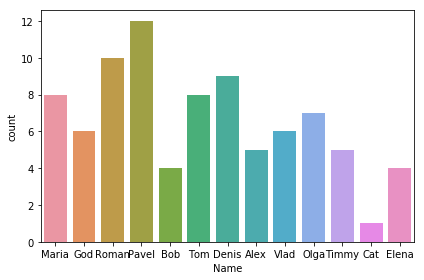

In [11]:
sns.countplot(data[0].Name)
plt.tight_layout()

Check, is UID unique

In [12]:
ind = data[0].UID.value_counts()[(data[0].UID.value_counts()>1)].index
data[0][data[0].UID.isin(ind)]

,UID,Name
0,4468,Maria
12,40156,Roman
26,40156,Roman
33,19047,Timmy
64,19047,Denis
81,4468,Denis


UID isn't unique. One UID can be used for several people

**numbers**

In [13]:
data[3].head()

,UID,Phone_Number
0,4468,221
1,46503,769
2,32112,338
3,2770,667
4,34913,580


In [14]:
data[3].shape

(85, 2)

Check uniqueness of UID

In [15]:
ind = data[3].UID.value_counts()[(data[3].UID.value_counts()>1)].index
data[3][data[3].UID.isin(ind)]

,UID,Phone_Number
0,4468,221
12,40156,976
26,40156,899
33,19047,888
64,19047,954
81,4468,732


One UID can be used for several numbers. This UIDs are the same as in table accounts.

Tables accounts and numbers have the same length. Check if the UIDs column are identical.

In [16]:
(data[0].UID == data[3].UID).all()

True

They are the same. So we can merge first two tables.

In [17]:
data[0]["Phone_Number"] = data[3].Phone_Number

In [18]:
data[0].head()

,UID,Name,Phone_Number
0,4468,Maria,221
1,46503,Maria,769
2,32112,God,338
3,2770,Roman,667
4,34913,Pavel,580


**call_forwarding**

In [19]:
data[1].head()

,From,To
0,221,580
1,769,684
2,338,338
3,667,580
4,580,448


In [20]:
data[1].shape

(49, 2)

In [21]:
data[1].From.nunique(), data[1].To.nunique()

(49, 43)

In [22]:
ind = data[1].To.value_counts()[(data[1].To.value_counts()>1)].index

# Телефоны, на которые переводят больше чем с одного телефона
data[1][data[1].To.isin(ind)].sort_values(by="To")

,From,To
44,234,103
45,638,103
6,272,428
42,335,428
4,580,448
47,319,448
11,904,563
41,476,563
0,221,580
3,667,580


**rates**

In [23]:
data[4].head()

,ID,Money,Description
0,1,0.00,for all incoming calls
1,2,0.00,for outgoing calls to phone numbers from Numbe...
2,3,0.04,for all other outgoing calls


In [24]:
data[4].Description[1]

'for outgoing calls to phone numbers from Numbers table'

**call_logs**

In [25]:
table = data[2]

In [26]:
# table.set_index("Call_id", inplace=True)

In [27]:
table.head()

,Call_id,Call_dir,From,To,UID,Timestamp_start,Timestamp_end
0,1,out,221,987,4468,2019-03-07 17:37:01,2019-03-07 17:37:41
1,2,out,769,814,46503,2019-03-07 17:37:30,2019-03-07 17:40:40
2,3,in,675,338,32112,2019-03-07 17:37:35,2019-03-07 17:39:21
3,4,in,447,448,2770,2019-03-07 17:36:56,2019-03-07 17:37:45
4,5,in,648,338,8953,2019-03-07 17:37:24,2019-03-07 17:39:03


We have call forwarding. So let's create new column.

In [28]:
table["with_forward_To"] = table.To.replace(data[1].From.values, data[1].To.values)

In [29]:
table[table.Call_dir == "in"].shape, table[table.Call_dir == "out"].shape

((527, 8), (472, 8))

Numbers of in and out calls are not equal. Now check for uniqueness each call.

In [30]:
table.groupby(["From","To","Timestamp_start"]).size().sort_values(ascending=False)

From  To   Timestamp_start    
799   959  2019-03-07 17:37:54    2
205   732  2019-03-07 17:39:07    2
1000  987  2019-03-07 17:40:00    1
538   554  2019-03-07 17:37:50    1
      496  2019-03-07 17:38:25    1
      448  2019-03-07 17:39:58    1
525   959  2019-03-07 17:39:22    1
      892  2019-03-07 17:38:34    1
      732  2019-03-07 17:40:05    1
           2019-03-07 17:39:01    1
           2019-03-07 17:38:20    1
           2019-03-07 17:37:34    1
      675  2019-03-07 17:37:30    1
      636  2019-03-07 17:39:48    1
      608  2019-03-07 17:39:17    1
           2019-03-07 17:37:55    1
           2019-03-07 17:37:29    1
538   732  2019-03-07 17:38:49    1
525   599  2019-03-07 17:38:23    1
      496  2019-03-07 17:38:48    1
      448  2019-03-07 17:36:55    1
      400  2019-03-07 17:40:01    1
           2019-03-07 17:38:32    1
      313  2019-03-07 17:39:34    1
      251  2019-03-07 17:39:40    1
           2019-03-07 17:39:04    1
      207  2019-03-07 17:39:18   

We should have two records for each call - one for in call, other for out. But there are only two occasions in the table.

In [31]:
table[(table.From == 799) & (table.To == 959)]

,Call_id,Call_dir,From,To,UID,Timestamp_start,Timestamp_end,with_forward_To
173,174,out,799,959,69521,2019-03-07 17:37:54,2019-03-07 17:39:10,959
178,179,out,799,959,3017,2019-03-07 17:37:54,2019-03-07 17:40:34,959


At first it looks like the same calls, but they have different duration and UID. Strange

Check calls between two clients for intersection.

In [32]:
calls = table.groupby(["From","To"]).size()
calls = calls[calls>1].sort_values(ascending=False).reset_index()

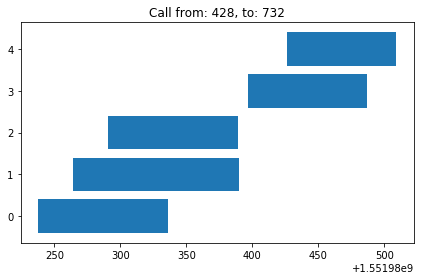

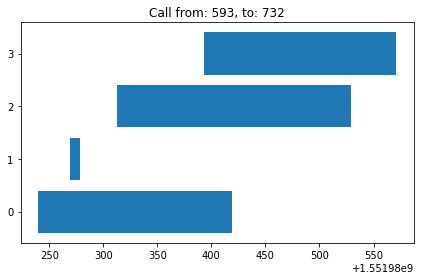

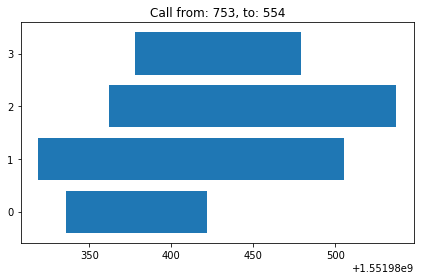

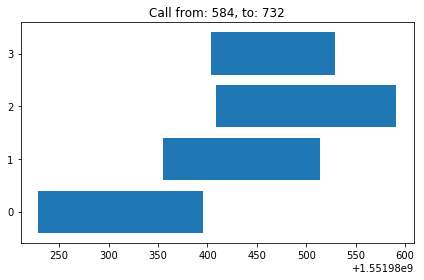

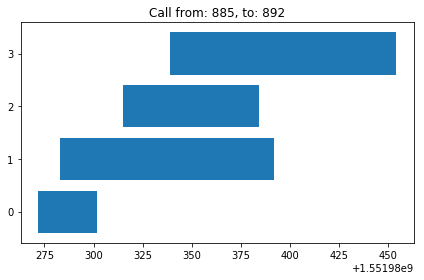

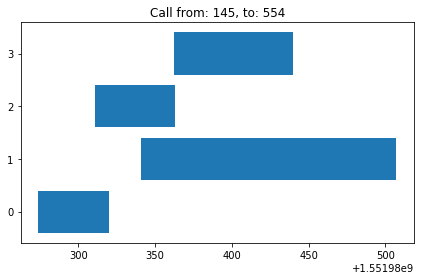

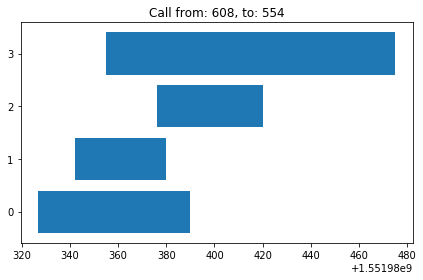

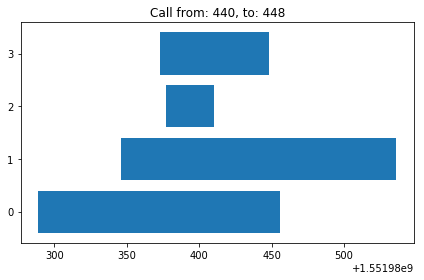

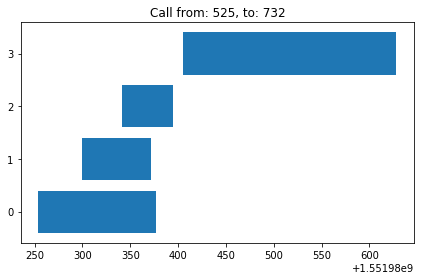

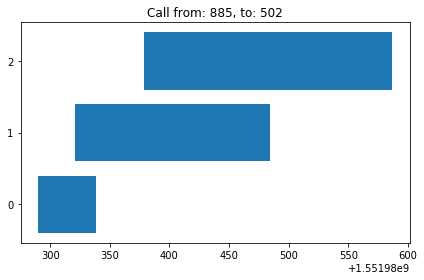

In [33]:
for i in range(10):
    call = table[(table.From == calls.iloc[i].From) & (table.To == calls.iloc[i].To)]
    fig,ax=plt.subplots()
    for j in range(call.shape[0]):
        start = call.iloc[j].Timestamp_start.to_period("S").ordinal
        end = call.iloc[j].Timestamp_end.to_period("S").ordinal
        ax.broken_barh([[start, end-start]], (j-0.4,0.8))
    ax.set_yticks(range(call.shape[0]))
    plt.title("Call from: "+str(calls.iloc[i].From)+", to: "+str(calls.iloc[i].To))
    plt.tight_layout()

We can see, that calls always intersect between each other. Strange too.

In [34]:
table["duration"] = table["Timestamp_end"] - table["Timestamp_start"]

In [35]:
table.Timestamp_start.min(), table.Timestamp_end.max()

(Timestamp('2019-03-07 17:36:52'), Timestamp('2019-03-07 17:44:03'))

In [36]:
table.duration.min(), table.duration.max()

(Timedelta('0 days 00:00:07'), Timedelta('0 days 00:04:06'))

All call logs are written for 7 minutes. Max call duration is 4 minutes.

How we could saw earlier, each call is unique. In each record we have client UID, who made call, or client UID, who get call. Find both of them for easier charges computation.

In [37]:
calls_out = table[table.Call_dir=="out"].drop(columns="Call_dir")
calls_in = table[table.Call_dir=="in"].drop(columns="Call_dir")

In [38]:
calls_out.head()

,Call_id,From,To,UID,Timestamp_start,Timestamp_end,with_forward_To,duration
0,1,221,987,4468,2019-03-07 17:37:01,2019-03-07 17:37:41,987,00:00:40
1,2,769,814,46503,2019-03-07 17:37:30,2019-03-07 17:40:40,814,00:03:10
7,8,684,732,56966,2019-03-07 17:36:52,2019-03-07 17:37:50,732,00:00:58
10,11,485,400,41468,2019-03-07 17:36:58,2019-03-07 17:38:42,400,00:01:44
11,12,858,502,88196,2019-03-07 17:37:11,2019-03-07 17:39:48,502,00:02:37


In [39]:
calls_out.rename({"UID": "UID_From"}, axis="columns", inplace=True)
calls_out = pd.merge(calls_out, data[3], how="left", left_on = "with_forward_To", right_on="Phone_Number")
calls_out = calls_out.drop(columns="Phone_Number").rename({"UID": "UID_To"}, axis="columns")

In [40]:
calls_in.rename({"UID": "UID_To"}, axis="columns", inplace=True)
calls_in = pd.merge(calls_in, data[3], how="left", left_on = "From", right_on="Phone_Number")
calls_in = calls_in.drop(columns="Phone_Number").rename({"UID": "UID_From"}, axis="columns")

In [41]:
display(calls_out.head())
display(calls_in.head())

,Call_id,From,To,UID_From,Timestamp_start,Timestamp_end,with_forward_To,duration,UID_To
0,1,221,987,4468,2019-03-07 17:37:01,2019-03-07 17:37:41,987,00:00:40,10163.0
1,2,769,814,46503,2019-03-07 17:37:30,2019-03-07 17:40:40,814,00:03:10,NaN
2,8,684,732,56966,2019-03-07 17:36:52,2019-03-07 17:37:50,732,00:00:58,4468.0
3,11,485,400,41468,2019-03-07 17:36:58,2019-03-07 17:38:42,400,00:01:44,NaN
4,12,858,502,88196,2019-03-07 17:37:11,2019-03-07 17:39:48,502,00:02:37,92800.0


,Call_id,From,To,UID_To,Timestamp_start,Timestamp_end,with_forward_To,duration,UID_From
0,3,675,338,32112,2019-03-07 17:37:35,2019-03-07 17:39:21,338,00:01:46,2502.0
1,4,447,448,2770,2019-03-07 17:36:56,2019-03-07 17:37:45,448,00:00:49,62995.0
2,5,648,338,8953,2019-03-07 17:37:24,2019-03-07 17:39:03,338,00:01:39,67835.0
3,6,954,448,34913,2019-03-07 17:37:07,2019-03-07 17:40:23,448,00:03:16,19047.0
4,7,769,581,74114,2019-03-07 17:37:25,2019-03-07 17:39:47,581,00:02:22,46503.0


In [42]:
calls_in.shape[0], calls_out.shape[0]

(527, 472)

In [43]:
#Number of NANs
calls_in[calls_in.UID_From.isnull()].shape[0], calls_out[calls_out.UID_To.isnull()].shape[0]

(73, 100)

In [44]:
columns=["Call_id", "From","To","with_forward_To","UID_From","UID_To","Timestamp_end","Timestamp_start","duration"]
new_table = pd.concat([calls_in, calls_out], ignore_index=True,axis=0,sort=True)[columns]
new_table

,Call_id,From,To,with_forward_To,UID_From,UID_To,Timestamp_end,Timestamp_start,duration
0,3,675,338,338,2502.0,32112.0,2019-03-07 17:39:21,2019-03-07 17:37:35,00:01:46
1,4,447,448,448,62995.0,2770.0,2019-03-07 17:37:45,2019-03-07 17:36:56,00:00:49
2,5,648,338,338,67835.0,8953.0,2019-03-07 17:39:03,2019-03-07 17:37:24,00:01:39
3,6,954,448,448,19047.0,34913.0,2019-03-07 17:40:23,2019-03-07 17:37:07,00:03:16
4,7,769,581,581,46503.0,74114.0,2019-03-07 17:39:47,2019-03-07 17:37:25,00:02:22
5,9,850,554,554,14414.0,67670.0,2019-03-07 17:38:33,2019-03-07 17:37:29,00:01:04
6,10,425,814,814,NaN,35629.0,2019-03-07 17:38:10,2019-03-07 17:36:56,00:01:14
7,13,563,400,400,72483.0,14744.0,2019-03-07 17:38:46,2019-03-07 17:36:55,00:01:51
8,16,829,400,400,33576.0,85247.0,2019-03-07 17:39:56,2019-03-07 17:37:04,00:02:52
9,17,636,959,959,6526.0,82439.0,2019-03-07 17:39:03,2019-03-07 17:37:37,00:01:26


Compute charges. According to rates, charges get from outcome calls, which don't include in Numbers table list.

In [45]:
dur_sec = pd.Series([x.seconds for x in new_table.duration])
new_table["charges"] = ((~new_table.UID_To.isin(data[3].UID))+0)*dur_sec*0.04

Total charges

In [46]:
new_table["charges"].sum()

2836.6000000000004

Let's find the most active users. The most active users make most of calls (number). Also we can take duration of calls as measure.

Clients, who have most of income calls.

In [47]:
most_calls_To = new_table.groupby("UID_To").size().sort_values(ascending=False)
most_calls_To

UID_To
4468.0     55
92800.0    31
21110.0    30
39388.0    29
44383.0    25
98103.0    21
16963.0    20
10163.0    12
80846.0    12
6526.0     12
14326.0    11
98148.0    11
32112.0    10
19047.0    10
2502.0     10
14414.0     9
39890.0     9
99499.0     8
38210.0     8
30415.0     8
52305.0     7
14584.0     7
45492.0     6
89257.0     6
22350.0     6
29936.0     6
99653.0     6
21539.0     5
17794.0     5
33576.0     5
           ..
54992.0     1
82848.0     1
55292.0     1
55983.0     1
56802.0     1
56929.0     1
56960.0     1
57039.0     1
57080.0     1
82439.0     1
51222.0     1
47613.0     1
48841.0     1
47653.0     1
47768.0     1
47969.0     1
48049.0     1
99892.0     1
48524.0     1
48593.0     1
48892.0     1
50869.0     1
49764.0     1
49856.0     1
49865.0     1
50002.0     1
50125.0     1
50148.0     1
50480.0     1
48285.0     1
Length: 425, dtype: int64

Clients, who make most of outcome calls.

In [48]:
most_calls_From = new_table.groupby("UID_From").size().sort_values(ascending=False)
most_calls_From

UID_From
40156.0    18
19047.0    12
71788.0    12
4468.0     12
54820.0    11
84028.0    11
16963.0    10
10163.0    10
67835.0    10
70829.0     9
46503.0     9
42996.0     9
63546.0     9
14744.0     9
32112.0     8
88196.0     8
22719.0     8
44737.0     8
34913.0     8
74303.0     8
74156.0     8
72483.0     8
40872.0     8
84116.0     8
98450.0     7
38210.0     7
89257.0     7
6526.0      7
75919.0     7
45535.0     7
           ..
45391.0     1
74548.0     1
44629.0     1
75263.0     1
44382.0     1
44257.0     1
75811.0     1
44012.0     1
43819.0     1
43740.0     1
43592.0     1
43350.0     1
76717.0     1
77299.0     1
77320.0     1
77810.0     1
41634.0     1
41492.0     1
78101.0     1
41117.0     1
78431.0     1
41034.0     1
40972.0     1
78511.0     1
40320.0     1
78757.0     1
79590.0     1
39856.0     1
39751.0     1
99672.0     1
Length: 403, dtype: int64

Let's combine this results and get top-10 of the most active clients.

In [49]:
most_calls = most_calls_To.add(most_calls_From,fill_value=0).sort_values(ascending=False)
most_calls.iloc[:10]

4468.0     67.0
92800.0    36.0
39388.0    34.0
21110.0    33.0
16963.0    30.0
44383.0    29.0
98103.0    27.0
10163.0    22.0
19047.0    22.0
80846.0    19.0
dtype: float64

Top-10 clients with highest charges.

In [50]:
new_table.groupby("UID_From").agg({"charges":np.sum}).sort_values(by="charges", ascending=False).iloc[:10]

,charges
UID_From,
40156.0,86.36
19047.0,55.32
84028.0,50.12
4468.0,48.68
46503.0,48.60
10163.0,47.96
63546.0,47.88
34913.0,45.44
71788.0,44.04
